# Field solver dispersion relation

This notebook studies the behavior of different field solvers in modeling the propagation of EM waves in unmagnetized plasmas, focusing on the dispersion relation. We initialize the simulation with a low temperature ($u_{th} = 0.001 c$) plasma, effectively injecting waves of all possible wavelengths into the simulation.

You can choose the field solver to use by changing the `import em1d* as zpic` line:
* `em1d` chooses the finite difference (FDTD) solver
* `em1ds` chooses the Pseudo-spectral solvers. In this case you can choose between the Pseudo Spectral Time Domain ("PSTD" - default) and the Pseudo Spectral Analytical Time Domain ("PSATD") solvers by setting the `emf.solver_type` property.

The timestep was chosen as $\Delta t = \Delta x/2$, to better illustrate the limitations of the finite difference solvers. In normal simulations you will get better results using:
* For the FDTD solver $\Delta t$ as close as possible to the cell size
* For the PSTD solver smaller values of $\Delta t$

We run the simulation up to a fixed number of iterations, controlled by the variable `niter`, storing the value of the EM field $E_z$ at every timestep so we can analyze them later:


In [1]:
# Choose between finite difference (em1d) and spectral (em1ds) codes
#import em1d as zpic
import em1ds as zpic

niter = 4000

electrons = zpic.Species( "electrons", -1.0, ppc = 64, uth=[0.001,0.001,0.001])
sim = zpic.Simulation( nx = 500, box = 50.0, dt = 0.5 * 0.1, species = electrons )

#sim.emf.solver_type = "PSTD"
sim.emf.solver_type = "PSATD"


# Run the simulation
import numpy as np
Ez_t = np.zeros((niter,sim.nx))

print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
while sim.n < niter:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    Ez_t[sim.n,:] = sim.emf.Ez
    sim.iter()

print("\nDone.")


Running simulation up to t = 200 ...
n = 3999, t = 199.95
Done.


## Electromagnetic Waves in Plasmas
To analyze the dispersion relation of the EM waves we use a 2D (Fast) Fourier transform of $E_z(x,t)$ field values that we stored during the simulation. The plot below shows the obtained power spectrum alongside the theoretical prediction.

Since the dataset is not periodic along $t$ we apply a windowing technique (Hanning) to the dataset to lower the background spectrum, and make the dispersion relation more visible.

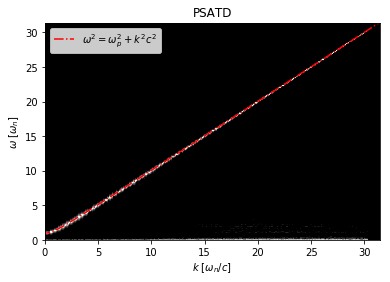

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# (omega,k) power spectrum

win = np.hanning(niter)
for i in range(sim.nx):
    Ez_t[:,i] *= win

sp = np.abs(np.fft.fft2(Ez_t))**2
sp = np.fft.fftshift( sp )

k_max = np.pi / sim.dx
omega_max = np.pi / sim.dt

plt.imshow( sp, origin = 'lower', norm=colors.LogNorm(vmin = 1e-7, vmax = 0.01),
           extent = ( -k_max, k_max, -omega_max, omega_max ),
           aspect = 'auto', cmap = 'gray')

k = np.linspace(-k_max, k_max, num = 512)
w=np.sqrt(1 + k**2)
plt.plot( k, w, label = "$\omega^2 = \omega_p^2 + k^2c^2$", color = 'r', ls = '-.' )


plt.ylim(0,k_max)
plt.xlim(0,k_max)
plt.xlabel("$k$ [$\omega_n/c$]")
plt.ylabel("$\omega$ [$\omega_n$]")

plt.title( sim.emf.solver_type )


plt.legend()

plt.savefig(sim.emf.solver_type+".svg")
plt.show()